# Modeling


We have saved 2 files after feature engineering. 
1. Crash data with other tables(people and vehicle) with all of new variables added
2. Same data with above but imputed columns with 90% missing rate

this time we will just do the most recent file which is imputed file



In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')
# File system manangement
import os

plt.style.use('fivethirtyeight')

In [2]:
!pip install lightgbm
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt
from sklearn import preprocessing

In [3]:
def model(features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['RD_NO']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['RD_NO', 'TARGET'])

    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
#     test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 2002)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
#     test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 2002)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
#         test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
#     submission = pd.DataFrame({'RD_NO': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return feature_importances, metrics

In [4]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [6]:
print(os.listdir("../input"))

['injury_train_people_vehicle_corrs_removed.csv', 'injury_train_people_vehicle_raw.csv', 'Traffic_Crashes_-_Crashes.csv', 'Traffic_Crashes_-_People.csv', 'Traffic_Crashes_-_Vehicles.csv', 'train_control_damage.csv', 'train_new.csv', 'train_people_vehicle_corrs_removed.csv', 'train_people_vehicle_raw.csv']


In [6]:
# read in data
categoricals = ['CRASH_DATE_EST_I', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE',
                'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND',
                'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
                'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE',
                'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION', 'STREET_NAME', 'PHOTOS_TAKEN_I',
                'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I',
                'MOST_SEVERE_INJURY', 'BEAT_OF_OCCURRENCE','CRASH_HOUR','CRASH_MONTH','CRASH_DAY_OF_WEEK','YEAR']
dtypes = dict.fromkeys(categoricals, 'category')


train_control = pd.read_csv('../input/injury_train_people_vehicle_corrs_removed.csv', dtype = dtypes)
train_control.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207101 entries, 0 to 207100
Data columns (total 42 columns):
RD_NO                            207101 non-null object
CRASH_DATE_EST_I                 13902 non-null category
POSTED_SPEED_LIMIT               207101 non-null int64
TRAFFIC_CONTROL_DEVICE           207101 non-null category
DEVICE_CONDITION                 207101 non-null category
WEATHER_CONDITION                207101 non-null category
LIGHTING_CONDITION               207101 non-null category
FIRST_CRASH_TYPE                 207101 non-null category
TRAFFICWAY_TYPE                  207101 non-null category
LANE_CNT                         136971 non-null object
ALIGNMENT                        207101 non-null object
ROADWAY_SURFACE_COND             207101 non-null category
ROAD_DEFECT                      207101 non-null category
REPORT_TYPE                      202378 non-null category
CRASH_TYPE                       207101 non-null category
INTERSECTION_RELATED_I       

## model


In [7]:
# read in data
categoricals = ['CRASH_DATE_EST_I', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'TRAFFICWAY_TYPE',
                'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ROADWAY_SURFACE_COND',
                'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
                'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE',
                'SEC_CONTRIBUTORY_CAUSE', 'STREET_DIRECTION', 'STREET_NAME', 'PHOTOS_TAKEN_I',
                'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I',
                'MOST_SEVERE_INJURY', 'BEAT_OF_OCCURRENCE','CRASH_HOUR','CRASH_MONTH','CRASH_DAY_OF_WEEK','YEAR']
dtypes = dict.fromkeys(categoricals, 'category')
train = pd.read_csv('../input/injury_train_people_vehicle_corrs_removed.csv',decimal = ',', dtype=dtypes, parse_dates = ['CRASH_DATE', 'DATE_POLICE_NOTIFIED'] )

In [8]:
train['YEAR'] = pd.DatetimeIndex(train['CRASH_DATE']).year

mask = train['YEAR']>2016

train=train.loc[mask,:]
train['YEAR']=train['YEAR'].astype('object')

train.shape


(207101, 877)

In [15]:
train= train.drop(columns='MOST_SEVERE_INJURY')

In [9]:
# drop same variables of control which is address info or date info.
drop_columns=['STREET_NO','LATITUDE','LONGITUDE','LOCATION','STREET_NAME','CRASH_DATE', 'DATE_POLICE_NOTIFIED']

#drop the features
train = train.drop(columns=drop_columns)

In [16]:
train.shape

(207101, 869)

In [17]:
# run and fit the model
fi_corr_removed, metrics_corr_removed = model(train)

Training Data Shape:  (207101, 4399)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.927315	train's binary_logloss: 0.345516	valid's auc: 0.912981	valid's binary_logloss: 0.403413
[400]	train's auc: 0.934559	train's binary_logloss: 0.330105	valid's auc: 0.913669	valid's binary_logloss: 0.399679
Early stopping, best iteration is:
[482]	train's auc: 0.936824	train's binary_logloss: 0.325149	valid's auc: 0.913777	valid's binary_logloss: 0.398363
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.927028	train's binary_logloss: 0.346013	valid's auc: 0.914849	valid's binary_logloss: 0.376434
[400]	train's auc: 0.934198	train's binary_logloss: 0.330734	valid's auc: 0.915344	valid's binary_logloss: 0.372996
Early stopping, best iteration is:
[417]	train's auc: 0.934755	train's binary_logloss: 0.329525	valid's auc: 0.915368	valid's binary_logloss: 0.372721
Training until validation scores don't improve for 100 rounds
[200]	train

In [18]:
metrics_corr_removed

,fold,train,valid
0,0,0.936824,0.913777
1,1,0.934755,0.915368
2,2,0.936152,0.916706
3,3,0.937188,0.919789
4,4,0.929499,0.920617
5,overall,0.934883,0.919500


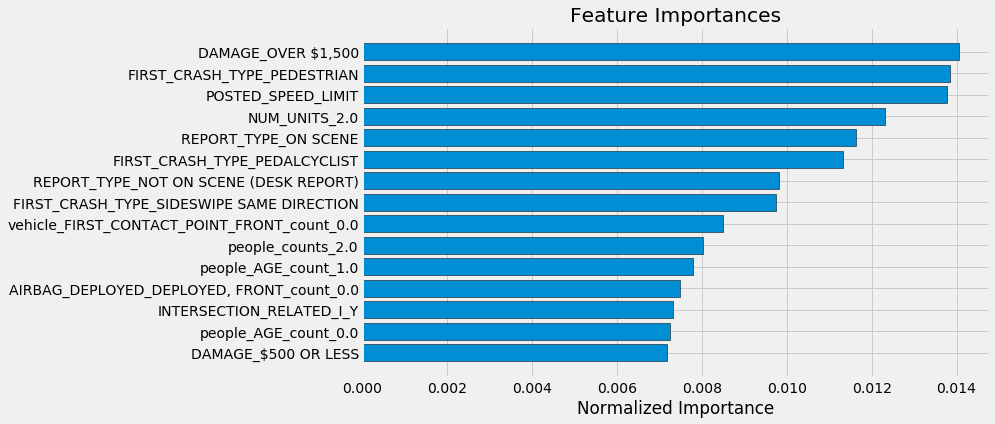

In [19]:
fi_corr_removed = plot_feature_importances(fi_corr_removed)